# LangGraph 
https://langchain-ai.github.io/langgraph/tutorials/introduction/

## Basic Chatbot

In [ ]:
from typing import Annotated # typing and Annotated are used to define the type of the state

from typing_extensions import TypedDict 

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
%pip install -q langchain-ollama

In [13]:
from langchain_ollama.chat_models import ChatOllama

llm = ChatOllama(model="llama3.2")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [14]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [15]:
graph = graph_builder.compile()

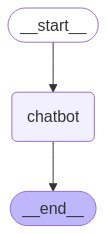

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: AI, or Artificial Intelligence, refers to the simulation of human intelligence in machines that are programmed to think like humans and mimic their actions. The term may also be applied to any machine that exhibits traits associated with a human mind such as learning and problem-solving.

There are several types of AI, including:

1. **Narrow or Weak AI**: This type of AI is designed to perform specific tasks, such as facial recognition, language translation, or playing chess.
2. **General or Strong AI**: This type of AI would have the ability to understand, learn, and apply its intelligence to solve any problem, much like a human.
3. **Superintelligence**: This type of AI is significantly more intelligent than the best human minds, with the potential to pose an existential risk to humans.

AI systems typically consist of three key components:

1. **Data**: The inputs that are used to train and improve the system.
2. **Algorithms**: The processes that are used to analyze and

## Enhancing the Chatbot with Tools

In [18]:
# !pip install googlesearch-python
import re
from googlesearch import search
import requests
from bs4 import BeautifulSoup
from pydantic import BaseModel, Field
from typing import Dict, List, Literal, Optional, Tuple, Type, Union


class toolInput(BaseModel):
    """Input for the Websearch tool."""

    query: str = Field(description="search query to look up")

class web_tool(BaseModel):
    args_schema: Type[BaseModel] = toolInput
    # print(args_schema.query("AI"))
    def __init__(self,max_result=2):
        self.max_result =max_result

    def validate_url(self,url: str) -> bool:
        """Validate the url.
        Args:
            url: The website url.
        """
        # Regular expression for validating a URL
        regex = re.compile(
            r'^(?:http|ftp)s?://'  # http:// or https://
            r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|'  # domain...
            r'localhost|'  # localhost...
            r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}|'  # ...or ipv4
            r'\[?[A-F0-9]*:[A-F0-9:]+\]?)'  # ...or ipv6
            r'(?::\d+)?'  # optional port
            r'(?:/?|[/?]\S+)$', re.IGNORECASE)

        if re.match(regex, url) is not None:
            return True
        else:
            return False
        
    def web_scrape(self, url: str) -> str:
        """Scrape the website for the url.

        Args:
            url: The website url.
        """
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html5lib') # html5lib parser is used to parse the content
        # soup = BeautifulSoup(page.text, 'html.parser')
        # print(soup.prettify())
        return soup.get_text()
        
    def invoke(self,topic):
        
        """
        Search, process and return the url and content list of dictionaries.
        Args:
            topic: search topic
        """
        results = search(topic, advanced=True)
        urls= [url.url for url in results if self.validate_url(url.url)][:self.max_result]
        final_list = []
        for url in urls:
            content = self.web_scrape(url) 
            # implement text preprocessing to filter the content.
            final_list.append({'url':url,'content':content})
        return final_list

In [13]:
tool = web_tool()
tool.invoke("Dr APJ Abdul Kalam")

[{'url': 'https://en.wikipedia.org/wiki/A._P._J._Abdul_Kalam',
  'content': '\n\nA. P. J. Abdul Kalam - Wikipedia\n(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available";var cookie=document.cookie.match(/(?:^|; )enwikimwclientpreferences=([^;]+)/);if(cookie){cookie[1].split(\'%2C\').forEach(function(pref){className=className.replace(new RegExp(\'(^| )\'+pref.replace(/-clientpref-\\w+$|[^\\w-]+/g,\'\')+\'-clientpref-\\\\w+( |$)\'),\'$1\'+pref+\'$2\');});}document.documentElement.className=className;}());RLCO

In [2]:
%pip install -Uq tavily-python langchain_community

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from dotenv import load_dotenv
load_dotenv("/Users/ajeet/Data/Development/.env")
TAVILY_API_KEY = os.getenv("TAVILY_KEY")
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [5]:
from langchain_community.tools import TavilySearchResults

tool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)
tool.invoke({"query": "Today's update from india."})

[{'title': 'Latest India News Headlines Today and Live Updates from India',
  'url': 'https://timesofindia.indiatimes.com/india',
  'content': "India / Feb 8, 2025 Delhi election results: How the OGs of AAP became Kejriwal’s biggest critics over the decade India / Feb 8, 2025 Delhi election results 2025: BJP ends Kejriwal's dream run in national capital - 5 strategies that failed to work for AAP chief India / Feb 8, 2025 Delhi Election Results 2025: Despite setback, AAP performs strongly in Muslim-majority assemblies Delhi assembly election results 2025 highlights: BJP leading on 48 seats, AAP on 22 Delhi assembly election results 2025: A decisive battle for power between AAP, BJP and Congress Delhi assembly elections results 2025: Who could be BJP’s CM pick if it defeats AAP and wins Delhi? Delhi assembly elections results 2025: Who could be BJP’s CM pick if it defeats AAP and wins Delhi?",
  'score': 0.7750779,
  'raw_content': "India News | Latest India News Headlines Today and Live

In [6]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.2")
# tool = web_tool()
# tools = [tool]
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [7]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [8]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

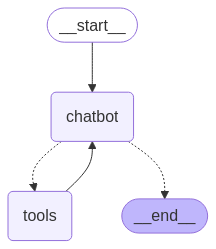

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'd be happy to provide you with some information about Holi celebrations in Vrindavan, a sacred town in India known for its rich cultural heritage and association with Lord Krishna.

**Holi Celebrations in Vrindavan:**

Holi is a significant festival in Hinduism, celebrated as the arrival of spring and the victory of good over evil. In Vrindavan, Holi is a grand celebration that attracts thousands of devotees and tourists every year.

* **Holika Dahan:** The festival begins with the Holika Dahan ceremony, where a bonfire is lit to symbolize the burning of Holika, the sister of Hiranyakashyap. This ritual is believed to purify the atmosphere and bring good fortune.
* **Rang Wali Holi:** After the Holika Dahan, the Rang Wali Holi celebration begins. Devotees gather in large numbers to play with colored powders, known as "gulaal," and exchange gifts. The festival is marked by joy, music, and dance.
* **Krishna Janmastami:** Vrindavan celebrates the birth of Lord Krishna on Kri